> This notebook contains code to generate the forward velocity of the car given the radar scans and the extrinsic calibration matrix.

Python Packages:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import time

from scipy.stats import chi2
from scipy.spatial.transform import Rotation as Rot
from tqdm.autonotebook import tqdm;
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn.metrics import mean_squared_error

/tmp/ipykernel_5665/921915617.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm;


In [2]:
# %matplotlib qt

%matplotlib inline
plt.rcParams['figure.dpi'] = 150

warnings.filterwarnings('ignore') 

Reading the radar data:

In [8]:
radar = pd.read_csv("../data/2022-09-06-12-55-08/front_right.csv")

In [9]:
radar.head()

,Time,x,y,z,azimuth,elevation,rcs,snr,speed
0,1.662483e+09,2.431823,-1.026242,0.051603,-0.399331,0.019548,-5.2,57.0,0.0
1,1.662483e+09,4.588445,-1.399326,-0.167518,-0.296008,-0.034907,-12.0,43.0,0.0
2,1.662483e+09,7.634209,2.281661,-1.074468,0.290423,-0.134041,-1.2,39.5,0.0
3,1.662483e+09,8.295595,-1.714915,0.390592,-0.203854,0.046077,-5.6,40.0,0.0
4,1.662483e+09,7.882394,-4.477823,0.513188,-0.516617,0.056549,2.2,42.0,0.0


In [13]:
ref = pd.read_csv("../data/2022-09-06-12-55-08/inspvax.csv")

In [14]:
ref['speed'] = np.sqrt(np.square(ref.loc[:,'east_velocity'].to_numpy()) +
                       np.square(ref.loc[:,'north_velocity'].to_numpy()) +
                       np.square(ref.loc[:,'up_velocity'].to_numpy()))
ref['std'] = np.zeros(ref.shape[0])

Propagating uncertainties:

In [15]:
ve = ref["east_velocity"].to_numpy()
vn = ref["north_velocity"].to_numpy()
vu = ref["up_velocity"].to_numpy()
ve_contribution = ve / np.sqrt(ve**2 + vn**2 + vu**2)
vn_contribution = vn / np.sqrt(ve**2 + vn**2 + vu**2)
vu_contribution = vu / np.sqrt(ve**2 + vn**2 + vu**2)
std_ref_speed = np.sqrt((ve_contribution * ref["east_velocity_stdev"].to_numpy())**2 +
                        (vn_contribution * ref["north_velocity_stdev"].to_numpy())**2 +
                        (vu_contribution * ref["up_velocity_stdev"].to_numpy())**2)
ref['std'] = std_ref_speed

In [16]:
grouped = radar.groupby(['Time'])

Checking average speed of each scan:

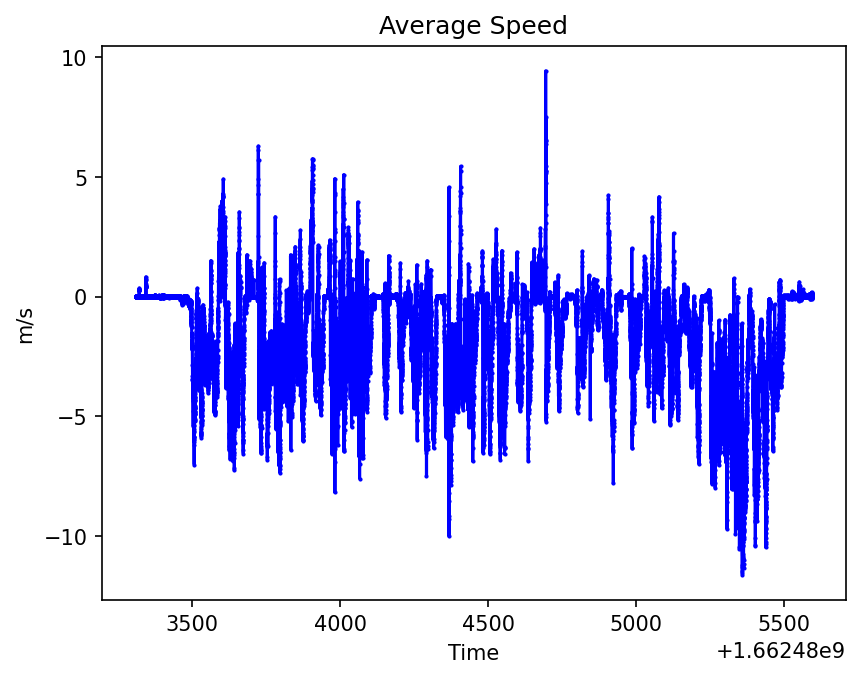

In [17]:
groupedS = radar.groupby(['Time']).mean()
plt.plot(groupedS.index, groupedS.speed, '-ob', markersize=1)
plt.title('Average Speed')
plt.xlabel('Time')
plt.ylabel('m/s')
plt.show();

Aligning Radar with Reference by getting the closest timestamp:

In [18]:
all_data = []
for t, group in grouped:
    temp = np.abs(ref['Time'].to_numpy() - t)
    id = np.argmin(temp)
    if temp[id] < 0.02:
        if group.shape[0] >= 3:
            all_data.append([*t, group.loc[:,['azimuth','elevation','speed']].to_numpy(), [ref['speed'].iat[id], ref['std'].iat[id]]])

Estimating the Radar Velocity:

In [25]:
model = RANSACRegressor(min_samples=3,
                        max_trials=100,
                        random_state=17)

In [26]:
radar_data = []
delta_t = []
pbar = tqdm(total=len(all_data))
for t, detections, ref in all_data:
    y = detections[:,2]
    Ai = (np.cos(detections[:,1]) * np.cos(detections[:,0])).reshape(-1,1)
    Aj = (np.cos(detections[:,1]) * np.sin(detections[:,0])).reshape(-1,1)
    Ak = (np.sin(detections[:,1])).reshape(-1,1)
    A = np.hstack((Ai,Aj,Ak))
    tic = time.time()
    try:
        model.fit(A,y)
        x = model.estimator_.coef_
    except:
        x = [np.nan,np.nan,np.nan]
    toc = time.time()
    delta_t.append(toc-tic)
    radar_data.append([t,x,ref])
    pbar.update(n=1)

  0%|          | 0/959 [00:00<?, ?it/s]

In [28]:
print(f'Mean inference time: {np.mean(delta_t)*1e3} ms')

Mean inference time: 4.052805825990233 ms


In [29]:
# radar_data

Using calibration made in Kingston:

Transformation matrix from front right radar to pwrpak7. 

In [30]:
R = Rot.from_euler('xyz', [0.04782, 0.00323, -0.73950], degrees=False)
# t = np.array([0.25252, -0.51511, -0.34276]) + np.array([0.480, -0.115, 0.395])
# T = np.eye(4)
# T[0:3,0:3] = R.as_matrix()
# T[0:3,3]   = t
# T

Transformation matrix from front left radar to pwrpak7. 

In [31]:
# R = Rot.from_euler('xyz', [-0.07209, -0.03804, 0.86847], degrees=False)

Transformation matrix from rear right radar to pwrpak7. 

In [32]:
# R = Rot.from_euler('xyz', [0.04212, 0.00280, -2.30320], degrees=False)

Transformation matrix from rear left radar to pwrpak7. 

In [33]:
# R = Rot.from_euler('xyz', [0.07741, -0.04312, 2.38532], degrees=False)

In [34]:
body_data = []
pbar = tqdm(total=len(radar_data))
for t, radar, ref in radar_data:
    spd = R.as_matrix().dot(radar)
    spd = np.linalg.norm(spd)
    body_data.append([t,ref[0],spd])
    pbar.update(n=1)

  0%|          | 0/959 [00:00<?, ?it/s]

In [35]:
body_data = np.array(body_data)

In [36]:
outliers = body_data[:,2] > 5e3

In [37]:
body_data = body_data[~outliers,:]

In [38]:
idx = np.isnan(body_data[:,2])

In [39]:
# alpha = 0.003
# s1 = chi2.isf(alpha, 1)
# sigma = np.sqrt(s1*np.square(body_data[:,-1]))

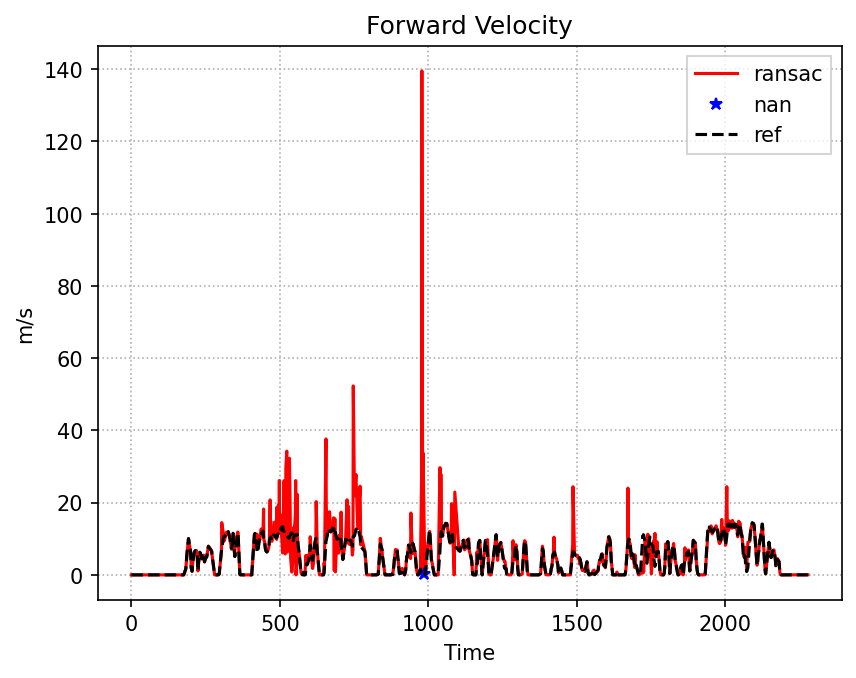

In [41]:
# plt.fill_between(body_data[:,0]-body_data[0,0], -sigma+body_data[:,1], sigma+body_data[:,1], color='b', alpha=0.2, label=str(100*(1-alpha)) + '% Confidence Bounds')
plt.plot(body_data[~idx,0]-body_data[0,0],body_data[~idx,2],'r',label='ransac')
plt.plot(body_data[idx,0]-body_data[0,0],body_data[idx,1],'*b',label='nan')
plt.plot(body_data[:,0]-body_data[0,0],body_data[:,1],'--k',label='ref')
# plt.axis('equal')
plt.legend(fancybox=False)
plt.xlabel('Time')
plt.ylabel('m/s')
plt.title('Forward Velocity')
plt.grid(linestyle=':')
plt.show()

In [42]:
print(f'RMSE: {mean_squared_error(body_data[~idx,1], body_data[~idx,2], squared=False)} m/s')

RMSE: 5.746933951693068 m/s


Save new csv file with transformed data:

In [27]:
df = pd.DataFrame(body_data,columns=['Time','ref_speed','speed'])

In [28]:
df.to_csv('../ransac/2022-09-27-14-46-03/front-right.csv',index=False)